# Loss functions

Loss functions are the target that a model strives to optimize. PyTorch provides a suite of popular loss functions, and we will explore their properties here. 

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

## Cross entropy

The following markdown table shows the tools in `torch` that implement different variations of the cross-entropy loss.

| Tool / Function                                  | Description                                                                |
|--------------------------------------------------|----------------------------------------------------------------------------|
| `torch.nn.CrossEntropyLoss`                      | Multiclass cross-entropy. Applies `log_softmax` + `nll_loss` internally.   |
| `torch.nn.functional.cross_entropy`              | Same as above, but functional API.                                         |
| `torch.nn.BCEWithLogitsLoss`                     | Binary cross-entropy with sigmoid activation built-in.                     |
| `torch.nn.BCELoss`                               | Binary cross-entropy, expects probabilities between 0 and 1.               |
| `torch.nn.functional.binary_cross_entropy_with_logits` | Functional version of `BCEWithLogitsLoss`.                           |
| `torch.nn.functional.binary_cross_entropy`       | Functional version of `BCELoss`.                                           |

### Binary cross entorpy

The realization of the cross-entropy loss for the binary case in PyTorch is represented by the functions: `torch.nn.functional.binary_cross_entropy` and `torch.nn.functional.binary_cross_entropy_with_logits`.

This loss function takes:

- `target`: the actual class labels, denoted as $y \in \{0,1\}$.
- `input`: the model's predictions, denoted as $\hat{y}$. For `torch.nn.functional.binary_cross_entropy`, must also satisfy $\hat{y} \in \left[0, 1\right]$. The `torch.nn.functional.binary_cross_entropy_with_logits` function handles this requirement by itself, as it applies the sigmoid activation internally.

---

The following cell generates two variables—one that provides better separation than the other. It visualizes the distributions of the classes over the predicted values, with the corresponding cross-entropy loss value displayed in the title.

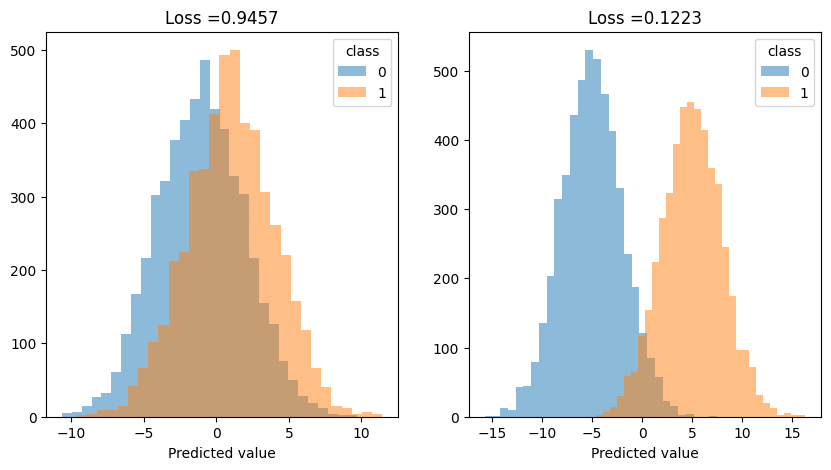

In [ ]:
samples = 10000

y = torch.randint(low=0, high=2, size=[samples]).to(torch.float)

pred_bad = torch.where(
    y==0,
    torch.normal(mean=-1, std=3, size=[samples]),
    torch.normal(mean=1, std=3, size=[samples])
)
pred_good = torch.where(
    y==0,
    torch.normal(mean=-5, std = 3, size=[samples]),
    torch.normal(mean=5, std= 3, size=[samples])
)

plt.figure(figsize=[10, 5])

def hist_plot(pred):

    plt.hist(pred[y==0], bins=30, alpha=0.5)
    plt.hist(pred[y==1], bins=30, alpha=0.5)
    
    loss_value = F.binary_cross_entropy(
        input=torch.sigmoid(pred), target=y
    ).item()
    plt.title("Loss =" + str(round(loss_value, 4)))
    
    plt.xlabel("Predicted value")
    plt.legend(["0", "1"], title="class")

plt.subplot(121)
hist_plot(pred_bad)

plt.subplot(122)
hist_plot(pred_good)

plt.show()

As you can see, the loss is lower in the case where the classes are better separated.

**Note**: If you try to pass inputs to `binary_cross_entropy` without applying the sigmoid transformation and they don't satisfy $\hat{y} \in \left[0, 1\right]$, you'll encounter an error.

In [ ]:
try:
    F.binary_cross_entropy(input=pred_good, target=y)
except Exception as e: print(e)

all elements of input should be between 0 and 1


In such cases, you should use `binary_cross_entropy_with_logits`. It returns the same value as `binary_cross_entropy` when the input is transformed with a sigmoid function.

In [ ]:
sigmoid = F.binary_cross_entropy(input=torch.sigmoid(pred_good), target=y)
with_logit = F.binary_cross_entropy_with_logits(input=pred_good, target=y)
print(sigmoid.item(), with_logit.item())

0.12228594720363617 0.12228594720363617


### Use cases

The exact binary version of the cross-entropy loss have to be used in cases where the target can only have two labels.

---

The following cell illustrates the most common case, in which each label in labels is a single binary value.

In [35]:
p = torch.rand(5)
y = torch.randint(low=0, high=2, size=[5], dtype=torch.float32)
print(p)
print(y)
F.binary_cross_entropy(y, p)

tensor([0.8729, 0.0369, 0.5808, 0.3849, 0.5945])
tensor([0., 0., 0., 1., 0.])


tensor(54.0062)

A more complex case occurs when each single observation in the data frame is labeled as a set of binary case.

For example, a single unit can describe the user's actions on the learning platform. Each label is a binary vector describing wheather the user the corresponding question correctly.

The following cell shows the application of the BCE to a batch of 10 samples. Each sample is represented by a vector of binary values. The `p` is a batch of predictions.

In [34]:
p = torch.rand(10, 5)
y = torch.randint(low=0, high=2, size=[10, 5], dtype=torch.float32)
print(p)
print(y)
F.binary_cross_entropy(y, p)

tensor([[0.9526, 0.3075, 0.5247, 0.0195, 0.3458],
        [0.3158, 0.8040, 0.2581, 0.5171, 0.7141],
        [0.7417, 0.2888, 0.5747, 0.6726, 0.5232],
        [0.8843, 0.8302, 0.1300, 0.3004, 0.2432],
        [0.4018, 0.6142, 0.6423, 0.8888, 0.2161],
        [0.2974, 0.0322, 0.9089, 0.1261, 0.7645],
        [0.7781, 0.7985, 0.8029, 0.9181, 0.5592],
        [0.8099, 0.9362, 0.2446, 0.8293, 0.5986],
        [0.9348, 0.5379, 0.1470, 0.4424, 0.5637],
        [0.7834, 0.3788, 0.3733, 0.4786, 0.7115]])
tensor([[1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 0., 0., 0.],
        [1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 1.],
        [1., 1., 0., 1., 1.],
        [0., 0., 1., 1., 1.],
        [1., 1., 0., 0., 1.],
        [0., 0., 0., 1., 0.]])


tensor(42.8067)

### Cross entropy

This loss function is commonly used for multi-class classification problems. In PyTorch's implementation, you need to provide:

- A batch $B$ of dimension $(n, K)$, where $n$ is the number of objects in the batch and $K$ is the number of classes. These represent the model's prediction scores.
- A vector $(y_1, y_2, ..., y_n)$, where $y_i$ is an integer from $0$ to $K-1$ indicating the true class label for each observation in the batch.

For a more detailed and accurate description of the sense check, please refer to the official [torch documentation page](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

---

Consider examples where the model made mistakes and where it was correct.

At the following cell, the true label for the observation was 0, but the model assigned high scores to all labels except 0. This is a mistake of the model. 

In [25]:
F.cross_entropy(
    torch.tensor([[0.1,0.5,0.7,0.5]]),
    torch.tensor([0])
)

tensor(1.7589)

In this case, the model predicted class 2 with high confidence, assigning low scores to all other classes. The true label was indeed 2, indicating a correct prediction by the model.

In [26]:
F.cross_entropy(
    torch.tensor([[0.1,0.1,0.7,0.1]]),
    torch.tensor([2])
)

tensor(0.9732)

Here is example that shows typical inputs for cross entropy loss.

In [59]:
n = 1000
classes_count = 5
predictions_batch = torch.randn(n, classes_count)
labels = torch.randint(low=0, high=classes_count, size=[n])
print("predictions batch")
print(predictions_batch[:10])
print("labels")
print(labels[:10])

F.cross_entropy(predictions_batch, labels)

predictions batch
tensor([[-0.8844, -0.3556,  0.9763,  1.2577, -0.6795],
        [ 0.2358, -0.7628, -1.4757,  1.0294, -0.8632],
        [ 0.4365, -0.9948,  0.0902, -0.7807, -0.3827],
        [ 2.1360,  1.1786, -0.0036,  0.0101, -0.4870],
        [ 0.1012, -0.2581,  1.4023,  0.5791,  1.3517],
        [ 0.4122,  0.9149,  1.0000,  0.8574,  0.2017],
        [-0.6575,  1.5868,  0.1800, -0.9720,  0.7293],
        [ 0.5361,  1.8960,  1.0395,  0.5292, -0.0472],
        [ 0.0543, -0.2939, -0.5856,  0.6681, -0.5274],
        [ 0.9524,  0.9101, -0.0125,  0.4696,  0.6906]])
labels
tensor([1, 3, 1, 1, 1, 3, 4, 3, 2, 1])


tensor(1.9175)